In [12]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import glob
from IPython.display import display
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from tqdm import tqdm_notebook
import random
import timm
import matplotlib.pyplot as plt
import numpy as np
import os



def plot_accuracy(train_acc, val_acc):
    plt.title('FOOD11')
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(train_loss, val_loss):
    plt.title('FOOD11')
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [13]:
# diretory of data
img_dir = [r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training", 
           r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\validation"]


class trainDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, train_list):
        super().__init__()
        self.root_dir = root_dir
        self.train_list = train_list
        self.img_names = [self.root_dir + os.sep + item for item in self.train_list]
        self.labels = [int(item.split(os.sep)[1].split('_')[0]) for item in self.train_list]

        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                             #transforms.RandomRotation(180),
                                             #transforms.ColorJitter(brightness=(0.3 if random.random()<0.5 else False),
                                              #                      contrast=(0.2 if random.random()<0.5 else False),
                                               #                     saturation=(0.2 if random.random()<0.5 else False),
                                                #                    hue=(0.1 if random.random()<0.5 else False)),
                                             #transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=(0.15, 0), resample=False),
                                             # transforms.RandomRotation(45),
                                             # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                             # transforms.Resize((448, 448)),
                                             
                                              transforms.Resize((245, 245)),
                                              transforms.CenterCrop((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])
                                            ])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        img = Image.open(self.img_names[i]).convert('RGB')
        return self.transform(img), self.labels[i]



class valDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, val_list):
        super().__init__()
        self.root_dir = root_dir
        self.val_list = val_list
        self.img_names = [self.root_dir + os.sep + item for item in self.val_list]
        self.labels = [int(item.split(os.sep)[1].split('_')[0]) for item in self.val_list]

        # PyTorch transforms
        self.transform = transforms.Compose([transforms.Resize((245, 245)),
                                             transforms.CenterCrop((224, 224)),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        img = Image.open(self.img_names[i]).convert('RGB')
        return self.transform(img), self.labels[i]


def random_split_train_val(train_dir, val_dir, split_ratio):
    train_names = ['training' + os.sep + item for item in os.listdir(train_dir)]
    val_names = ['validation' + os.sep + item for item in os.listdir(val_dir)]
    all_names = train_names + val_names
    nums = len(all_names)
    ratio = split_ratio
    random.shuffle(all_names)
    new_val = all_names[:round(nums * ratio)]
    new_train = all_names[round(nums * ratio):]
    return new_train, new_val

root_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11"
train_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training\\"
val_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\validation\\"
new_train, new_val = random_split_train_val(train_dir, val_dir, 0.1)
train_set = trainDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data", new_train)
print(len(train_set))
val_set = valDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data", new_val)
print(len(val_set))

val2_names = os.listdir(root_dir + os.sep + "evaluation" + os.sep)
val2_list = ["evaluation" + os.sep + item for item in val2_names]
val2_set = valDataset(root_dir, val2_list)

print(len(val2_set))
# ind = 7000
# train_data = trainDataset(img_dir)
# print(len(train_data))
# val_data = valDataset([img_dir[1]])
# img, label = train_data[ind]

11966
1330
3347


In [14]:

batch_size = 25
test_split = 0.05


train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
val2_dl = torch.utils.data.DataLoader(val2_set, batch_size=batch_size)

            
            
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#resnet50 = models.resnext50_32x4d(pretrained=True)
#set_parameter_requires_grad(resnet50, True)
#fc_features = resnet50.fc.in_features
#resnet50.fc = nn.Linear(fc_features, 11)

#import timm

resnet50 = timm.create_model('mixnet_l', pretrained=True)
#set_parameter_requires_grad(resnet50, True)
resnet50.classifier = nn.Linear(1536, 11)
print(resnet50)

#unfreezing some of the bottom resnext layers in order to get better accuray , after reaching layers 3 , we started to get 
#some memory error du to cuda ram problem. 
#next(resnet50.layer4[1].conv1.parameters()).requires_grad = True
#next(resnet50.layer4[1].conv2.parameters()).requires_grad = True
#next(resnet50.layer4[1].conv3.parameters()).requires_grad = True
#next(resnet50.layer4[2].conv1.parameters()).requires_grad = True
#next(resnet50.layer4[2].conv2.parameters()).requires_grad = True
#next(resnet50.layer4[2].conv3.parameters()).requires_grad = True
#next(resnet50.layer4[0].conv1.parameters()).requires_grad = True
#next(resnet50.layer4[0].conv2.parameters()).requires_grad = True
#next(resnet50.layer4[0].conv3.parameters()).requires_grad = True
#next(resnet50.layer3[22].conv1.parameters()).requires_grad = True
#next(resnet50.layer3[22].conv2.parameters()).requires_grad = True
#next(resnet50.layer3[22].conv3.parameters()).requires_grad = True

GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_pw): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): MixedConv2d(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running

)


In [16]:
torch.cuda.empty_cache()
LEARNING_RATE = 0.01
net = resnet50
net = net.cuda()
N_EPOCHS = 50


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(),lr = LEARNING_RATE, momentum=0.9,weight_decay=1e-4) 
# MILESTONE = [1, 20, 30, 40]
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONE, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 6)

In [6]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_val2_loss = []
epoch_val2_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
best_val2_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    net.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_dl)), "learning rate:", scheduler.get_lr()[0])
    
    scheduler.step()
    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    net.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = net(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(net.state_dict(), 'mixnet_l.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

    
    
    running_val2_loss = 0
    running_val2_accuracy = 0
    
    for i, batch in enumerate(val2_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = net(x)
            loss = criterion(y, labels)

            running_val2_loss += loss.item()
            running_val2_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val2_accuracy/float(len(val2_set))
    if acc > best_val2_acc:
        best_val2_acc = acc
        torch.save(net.state_dict(), 'mixnet_l2.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val2_loss/float(len(val2_set)))
    epoch_val2_loss.append(running_val2_loss/len(val2_set))
    epoch_val2_acc.append(running_val2_accuracy/len(val2_set))
    

#Training accuracy: 61.29% Training loss: 1.310349090006745 learning rate: 0.0004999999999999924
#Validation accuracy:78.43% Validation loss: 0.02216043197726369
#EPOCH: 1 
# LEARNING RATES TOO LOW 

#Training accuracy: 79.99% Training loss: 0.6488370027839173 learning rate: 6.698729810777737e-05
#Validation accuracy:82.36% Validation loss: 0.016642803085137037
#EPOCH: 2


#resnext50
#Training accuracy: 72.03% Training loss: 0.8572557178827432 learning rate: 0.001
#Validation accuracy:83.88% Validation loss: 0.0037515729383372706
#EPOCH: 1

#Training accuracy: 94.75% Training loss: 0.17378924873012763 learning rate: 0.001
#Validation accuracy:89.53% Validation loss: 0.0026218994257227674
#EPOCH: 14



#mixnet

#Training accuracy: 99.87% Training loss: 0.0056521773303466446 learning rate: 0.006545084971874732
#Validation accuracy:96.71% Validation loss: 0.0057580280123060035
#EPOCH: 48

EPOCH: 0



Training accuracy: 80.10% Training loss: 0.6112984815818532 learning rate: 0.01
Validation accuracy:90.30% Validation loss: 0.011516725969381799
Validation accuracy:92.77% Validation loss: 0.009226846136375349
EPOCH: 1



Training accuracy: 93.86% Training loss: 0.18853477709819727 learning rate: 0.009330127018922194
Validation accuracy:91.20% Validation loss: 0.010809611249364968
Validation accuracy:93.46% Validation loss: 0.008607149193848617
EPOCH: 2



Training accuracy: 97.58% Training loss: 0.07873964009054067 learning rate: 0.0075
Validation accuracy:93.31% Validation loss: 0.00842852113432342
Validation accuracy:94.41% Validation loss: 0.007342850192951404
EPOCH: 3



Training accuracy: 98.72% Training loss: 0.042879970831989016 learning rate: 0.005
Validation accuracy:93.38% Validation loss: 0.007610915866645431
Validation accuracy:94.95% Validation loss: 0.0066274331319927755
EPOCH: 4



Training accuracy: 99.31% Training loss: 0.025992481322693668 learning rate: 0.0025000000000000014
Validation accuracy:93.68% Validation loss: 0.008018695027042264
Validation accuracy:94.89% Validation loss: 0.006765784654536551
EPOCH: 5



Training accuracy: 99.52% Training loss: 0.020999938693740415 learning rate: 0.0006698729810778065
Validation accuracy:93.61% Validation loss: 0.00786574789098835
Validation accuracy:95.10% Validation loss: 0.006448028364865299
EPOCH: 6



Training accuracy: 99.51% Training loss: 0.021604041852803593 learning rate: 0.0
Validation accuracy:93.76% Validation loss: 0.007438464452953715
Validation accuracy:95.01% Validation loss: 0.006674919438844102
EPOCH: 7



Training accuracy: 99.47% Training loss: 0.02090458806679732 learning rate: 0.0006698729810778059
Validation accuracy:93.98% Validation loss: 0.007823096079527771
Validation accuracy:94.92% Validation loss: 0.006513157828453865
EPOCH: 8



Training accuracy: 99.50% Training loss: 0.01901356425145563 learning rate: 0.002499999999999998
Validation accuracy:93.83% Validation loss: 0.007854304166468687
Validation accuracy:95.13% Validation loss: 0.0065745253776037195
EPOCH: 9



Training accuracy: 99.54% Training loss: 0.017952688824031053 learning rate: 0.004999999999999999
Validation accuracy:93.53% Validation loss: 0.007995627259772578
Validation accuracy:94.89% Validation loss: 0.007205290967462351
EPOCH: 10



Training accuracy: 99.48% Training loss: 0.020511365964199904 learning rate: 0.0075
Validation accuracy:93.16% Validation loss: 0.009508933677317057
Validation accuracy:94.77% Validation loss: 0.00771602904200684
EPOCH: 11



Training accuracy: 99.16% Training loss: 0.02664117372247472 learning rate: 0.009330127018922192
Validation accuracy:92.86% Validation loss: 0.010279427032525603
Validation accuracy:94.65% Validation loss: 0.007990778115016476
EPOCH: 12



Training accuracy: 99.12% Training loss: 0.028966717310757756 learning rate: 0.01
Validation accuracy:93.16% Validation loss: 0.009799428990187781
Validation accuracy:94.68% Validation loss: 0.007837987263860308
EPOCH: 13



Training accuracy: 99.26% Training loss: 0.025656683068966863 learning rate: 0.009330127018922192
Validation accuracy:93.08% Validation loss: 0.010222456212544155
Validation accuracy:94.86% Validation loss: 0.007757716485594852
EPOCH: 14



Training accuracy: 99.52% Training loss: 0.015400482374457312 learning rate: 0.007500000000000002
Validation accuracy:92.78% Validation loss: 0.010348580058671087
Validation accuracy:94.80% Validation loss: 0.00794970018116732
EPOCH: 15



Training accuracy: 99.71% Training loss: 0.010769143296913137 learning rate: 0.005000000000000005
Validation accuracy:93.76% Validation loss: 0.009484663528838384
Validation accuracy:95.13% Validation loss: 0.007696973619176084
EPOCH: 16



Training accuracy: 99.84% Training loss: 0.007403831067352263 learning rate: 0.002500000000000004
Validation accuracy:94.06% Validation loss: 0.009061929988902399
Validation accuracy:95.52% Validation loss: 0.007269896334828475
EPOCH: 17



Training accuracy: 99.86% Training loss: 0.006387081375183481 learning rate: 0.0006698729810778059
Validation accuracy:93.91% Validation loss: 0.008501757133342466
Validation accuracy:95.40% Validation loss: 0.007003734108259125
EPOCH: 18



Training accuracy: 99.83% Training loss: 0.0070525927260334095 learning rate: 0.0
Validation accuracy:93.83% Validation loss: 0.008518454688251074
Validation accuracy:95.79% Validation loss: 0.007005631628332961
EPOCH: 19



Training accuracy: 99.89% Training loss: 0.0058249547769122206 learning rate: 0.0006698729810778042
Validation accuracy:93.83% Validation loss: 0.008892748538882618
Validation accuracy:95.52% Validation loss: 0.0069173170119602055
EPOCH: 20



Training accuracy: 99.87% Training loss: 0.006238544456631158 learning rate: 0.0025000000000000014
Validation accuracy:94.36% Validation loss: 0.008396040621612753
Validation accuracy:95.58% Validation loss: 0.007023885836883817
EPOCH: 21



Training accuracy: 99.85% Training loss: 0.006474097653930459 learning rate: 0.0049999999999999975
Validation accuracy:93.68% Validation loss: 0.008778446821909034
Validation accuracy:95.25% Validation loss: 0.007222738465099497
EPOCH: 22



Training accuracy: 99.79% Training loss: 0.007054723239891325 learning rate: 0.007499999999999995
Validation accuracy:93.38% Validation loss: 0.00953848792189256
Validation accuracy:95.16% Validation loss: 0.007506405316291553
EPOCH: 23



Training accuracy: 99.67% Training loss: 0.010213012432913823 learning rate: 0.009330127018922189
Validation accuracy:93.38% Validation loss: 0.010532393824498176
Validation accuracy:94.74% Validation loss: 0.007770013201260996
EPOCH: 24



Training accuracy: 99.52% Training loss: 0.014135770358470665 learning rate: 0.01
Validation accuracy:93.08% Validation loss: 0.011379808536730707
Validation accuracy:94.65% Validation loss: 0.008856715034975874
EPOCH: 25



Training accuracy: 99.43% Training loss: 0.01859928293023375 learning rate: 0.009330127018922192
Validation accuracy:93.76% Validation loss: 0.008850750520355348
Validation accuracy:95.22% Validation loss: 0.007528333208647393
EPOCH: 26



Training accuracy: 99.77% Training loss: 0.010075074009167002 learning rate: 0.0075
Validation accuracy:93.98% Validation loss: 0.009251000492054972
Validation accuracy:95.16% Validation loss: 0.007752603708869981
EPOCH: 27



Training accuracy: 99.87% Training loss: 0.006490731198098041 learning rate: 0.005000000000000003
Validation accuracy:93.91% Validation loss: 0.008397993630424573
Validation accuracy:95.10% Validation loss: 0.007466462641050403
EPOCH: 28



Training accuracy: 99.85% Training loss: 0.005423636314466922 learning rate: 0.0025000000000000053
Validation accuracy:94.51% Validation loss: 0.00806988682398744
Validation accuracy:95.58% Validation loss: 0.007017881480495226
EPOCH: 29



Training accuracy: 99.87% Training loss: 0.005004706146378235 learning rate: 0.0006698729810778071
Validation accuracy:94.51% Validation loss: 0.008523059846864859
Validation accuracy:95.52% Validation loss: 0.0072075176797462
EPOCH: 30



Training accuracy: 99.91% Training loss: 0.004267676400251544 learning rate: 0.0
Validation accuracy:93.98% Validation loss: 0.008630592480253278
Validation accuracy:95.22% Validation loss: 0.007020843161942028
EPOCH: 31



Training accuracy: 99.93% Training loss: 0.0036410241350789503 learning rate: 0.0006698729810778037
Validation accuracy:94.44% Validation loss: 0.00865574032155783
Validation accuracy:95.37% Validation loss: 0.007077076057479824
EPOCH: 32



Training accuracy: 99.93% Training loss: 0.0036350788606629323 learning rate: 0.0024999999999999922
Validation accuracy:94.14% Validation loss: 0.008760594803475796
Validation accuracy:95.40% Validation loss: 0.007400785462002745
EPOCH: 33



Training accuracy: 99.91% Training loss: 0.004762918213156338 learning rate: 0.005000000000000005
Validation accuracy:94.36% Validation loss: 0.00874562524204384
Validation accuracy:95.16% Validation loss: 0.007318124430565001
EPOCH: 34



Training accuracy: 99.91% Training loss: 0.004143557345647073 learning rate: 0.007500000000000002
Validation accuracy:95.19% Validation loss: 0.00837644132505621
Validation accuracy:95.67% Validation loss: 0.007093408538383914
EPOCH: 35



Training accuracy: 99.96% Training loss: 0.0030611863151388434 learning rate: 0.009330127018922192
Validation accuracy:94.74% Validation loss: 0.009094705899190017
Validation accuracy:95.55% Validation loss: 0.006980408172353678
EPOCH: 36



Training accuracy: 99.86% Training loss: 0.004921178455458891 learning rate: 0.01
Validation accuracy:94.44% Validation loss: 0.00866128964049508
Validation accuracy:95.28% Validation loss: 0.007822438694066538
EPOCH: 37



Training accuracy: 99.89% Training loss: 0.005228500696959565 learning rate: 0.009330127018922196
Validation accuracy:93.76% Validation loss: 0.009592430733033338
Validation accuracy:94.98% Validation loss: 0.007353892088082781
EPOCH: 38



Training accuracy: 99.80% Training loss: 0.006603735858807188 learning rate: 0.007500000000000009
Validation accuracy:94.14% Validation loss: 0.009228333839258229
Validation accuracy:95.28% Validation loss: 0.007732060167870194
EPOCH: 39



Training accuracy: 99.93% Training loss: 0.004583180928229144 learning rate: 0.005000000000000013
Validation accuracy:94.29% Validation loss: 0.009278715043774012
Validation accuracy:95.34% Validation loss: 0.007271232890899386
EPOCH: 40



Training accuracy: 99.92% Training loss: 0.0034111790968863963 learning rate: 0.0024999999999999983
Validation accuracy:94.14% Validation loss: 0.00890166048058499
Validation accuracy:95.37% Validation loss: 0.007308444199736455
EPOCH: 41



Training accuracy: 99.90% Training loss: 0.003235381245352288 learning rate: 0.0006698729810778165
Validation accuracy:94.36% Validation loss: 0.008482149873168253
Validation accuracy:95.58% Validation loss: 0.007050730115901342
EPOCH: 42



Training accuracy: 99.95% Training loss: 0.002887963641783121 learning rate: 0.0
Validation accuracy:93.91% Validation loss: 0.009289317624752857
Validation accuracy:95.34% Validation loss: 0.007611898155318704
EPOCH: 43



Training accuracy: 99.95% Training loss: 0.002356500274763979 learning rate: 0.0006698729810778032
Validation accuracy:94.51% Validation loss: 0.008857577418524656
Validation accuracy:95.37% Validation loss: 0.007416850151846618
EPOCH: 44



Training accuracy: 99.94% Training loss: 0.0027781107981122936 learning rate: 0.0024999999999999914
Validation accuracy:94.14% Validation loss: 0.00853101779483355
Validation accuracy:95.43% Validation loss: 0.007279027300086898
EPOCH: 45



Training accuracy: 99.97% Training loss: 0.0020739637412344283 learning rate: 0.0050000000000000044
Validation accuracy:94.44% Validation loss: 0.00890200067505405
Validation accuracy:95.34% Validation loss: 0.007169123312287808
EPOCH: 46



Training accuracy: 99.92% Training loss: 0.0031602475298004454 learning rate: 0.007499999999999986
Validation accuracy:94.51% Validation loss: 0.009265210870791251
Validation accuracy:95.52% Validation loss: 0.007429764283136077
EPOCH: 47



Training accuracy: 99.90% Training loss: 0.003822066345509292 learning rate: 0.009330127018922192
Validation accuracy:94.89% Validation loss: 0.008049758502213929
Validation accuracy:95.49% Validation loss: 0.007798865705435475
EPOCH: 48



Training accuracy: 99.84% Training loss: 0.00649634229954541 learning rate: 0.01
Validation accuracy:94.59% Validation loss: 0.008909932548550914
Validation accuracy:95.73% Validation loss: 0.007681630439426814
EPOCH: 49



Training accuracy: 99.91% Training loss: 0.003857019683012734 learning rate: 0.009330127018922198
Validation accuracy:94.36% Validation loss: 0.009220961567336787
Validation accuracy:95.34% Validation loss: 0.007797307759654485


In [4]:
batch_size = 25
#Restarting training at the best validation accuracy epoch , with different scheduler and learning rates 
# mixnet best accuracy for pretraining 96.79%
# restart with again cosine and after this one output the best model we will continue last training with multistep lr

restart_training = timm.create_model('mixnet_xl', pretrained=True)
restart_training.classifier = nn.Linear(1536, 11)
restart_training.load_state_dict(torch.load('model_mixnet_val2.pkl'))


def random_split_train_val(train_dir, split_ratio):
    train_names = ['evaluation' + os.sep + item for item in os.listdir(train_dir)]
    all_names = train_names
    nums = len(all_names)
    ratio = split_ratio
    random.shuffle(all_names)
    return all_names



root_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11\evaluation\\"
train_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training\\"
val_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11\validation\\"
new_train = random_split_train_val(root_dir, 0.1)
train_set = trainDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11", new_train)
print(train_set[0])
print(len(train_set))
val_set = valDataset(r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11", new_train)
print(val_set[0])
print(len(val_set))


train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
val2_dl = torch.utils.data.DataLoader(val2_set, batch_size=batch_size)

torch.cuda.empty_cache()
LEARNING_RATE = 0.001
restart_training.cuda()


N_EPOCHS = 50


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.SGD(restart_training.parameters(),lr = LEARNING_RATE, momentum=0.9,weight_decay=1e-4) 
MILESTONE = [1, 20, 30, 40]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONE, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = (N_EPOCHS // 9) + 1)



(tensor([[[ 0.6906,  0.6906,  0.8618,  ..., -0.0972, -0.0972, -0.0972],
         [ 0.7762,  0.8618,  0.7419,  ..., -0.0972, -0.0972, -0.1314],
         [ 0.7419,  0.8618,  0.8276,  ..., -0.0972, -0.0972, -0.1314],
         ...,
         [-2.0837, -2.1008, -2.1179,  ..., -0.2856, -0.2684, -0.2342],
         [-2.1008, -2.1008, -2.1179,  ..., -0.3198, -0.3198, -0.3198],
         [-2.0837, -2.1008, -2.1179,  ..., -0.3027, -0.3369, -0.3369]],

        [[ 1.3256,  1.3256,  1.5007,  ...,  0.0826,  0.0826,  0.0826],
         [ 1.3957,  1.5007,  1.3606,  ...,  0.0826,  0.0826,  0.0476],
         [ 1.3431,  1.4832,  1.4482,  ...,  0.0826,  0.0826,  0.0476],
         ...,
         [-1.7381, -1.8081, -1.8256,  ..., -0.0749, -0.0399, -0.0224],
         [-1.7731, -1.8081, -1.8256,  ..., -0.1099, -0.1099, -0.1099],
         [-1.7556, -1.7906, -1.8256,  ..., -0.0924, -0.1275, -0.1275]],

        [[ 1.7163,  1.7337,  1.8731,  ...,  0.0082,  0.0082, -0.0267],
         [ 1.8208,  1.9254,  1.7511,  ...,  

In [5]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_val2_loss = []
epoch_val2_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
best_val2_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    restart_training.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = restart_training(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_dl)), "learning rate:", scheduler.get_lr()[0])
    
    scheduler.step()
    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    restart_training.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = restart_training(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(restart_training.state_dict(), 'model_mixnet_restart2.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

    
    
    running_val2_loss = 0
    running_val2_accuracy = 0
    
    for i, batch in enumerate(val2_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = restart_training(x)
            loss = criterion(y, labels)

            running_val2_loss += loss.item()
            running_val2_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val2_accuracy/float(len(val2_set))
    if acc > best_val2_acc:
        best_val2_acc = acc
        torch.save(restart_training.state_dict(), 'model_mixnet_val2_restart2.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val2_loss/float(len(val2_set)))
    epoch_val2_loss.append(running_val2_loss/len(val2_set))
    epoch_val2_acc.append(running_val2_accuracy/len(val2_set))
    

EPOCH: 0



Training accuracy: 94.62% Training loss: 0.2062174639397009 learning rate: 0.001
Validation accuracy:98.12% Validation loss: 0.0025892850150289024
Validation accuracy:98.12% Validation loss: 0.002589116563666886
EPOCH: 1


KeyboardInterrupt: 

In [4]:
restart_training = timm.create_model('mixnet_xl', pretrained=True)
restart_training.classifier = nn.Linear(1536, 11)
restart_training.load_state_dict(torch.load('model_mixnet.pkl'))



torch.cuda.empty_cache()
LEARNING_RATE = 0.001
restart_training.cuda()


N_EPOCHS = 50

batch_size = 25
test_split = 0.1

N_test_samples = round(test_split * len(train_data))
train_set, val_set = torch.utils.data.random_split(train_data,[len(train_data) - N_test_samples, N_test_samples])

train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

p = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11\evaluation"
tmp = valDataset([p])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(valDataset([p]), batch_size=batch_size)


train_set = train_data
val_set = tmp

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(restart_training.parameters(),lr = LEARNING_RATE, momentum=0.9,weight_decay=1e-4) 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 5)

In [5]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
flag = 0
N_EPOCHS = 50
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    restart_training.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = restart_training(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_dl)), "learning rate:", scheduler.get_lr()[0])
    
    scheduler.step()
    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    restart_training.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = restart_training(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(restart_training.state_dict(), 'model_mixnet_restart1.pkl')
        flag = 0
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

EPOCH: 0



Training accuracy: 99.53% Training loss: 0.017840567157789845 learning rate: 0.001
Validation accuracy:99.85% Validation loss: 0.00021236590418309898
EPOCH: 1



Training accuracy: 99.57% Training loss: 0.017373887183357833 learning rate: 0.0009045084971874737
Validation accuracy:99.92% Validation loss: 0.00016884828118530375
EPOCH: 2



Training accuracy: 99.58% Training loss: 0.015941037162442086 learning rate: 0.0006545084971874737
Validation accuracy:99.85% Validation loss: 0.0002641361776154656
EPOCH: 3


KeyboardInterrupt: 

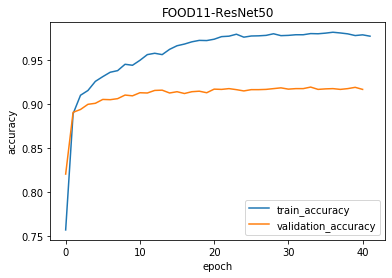

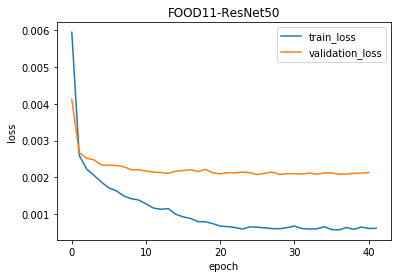

In [21]:
plot_accuracy(epoch_train_acc, epoch_val_acc) 
plot_loss(epoch_train_loss, epoch_val_loss)

In [46]:

mixnet = timm.create_model('mixnet_xl', pretrained=True)
mixnet.classifier = nn.Linear(1536, 11)
#mixnet.load_state_dict(torch.load("model_mixnet_val2_restart2.pkl"))
mixnet.load_state_dict(torch.load("model_resNext50.pkl"))
mixnet.cuda()
mixnet.eval()
running_test_accuracy = 0
for i, batch in enumerate(val2_dl):
    with torch.no_grad():
        x = batch[0]
        labels = batch[1]
        x = x.cuda()
        x = x.cuda()
        labels = labels.cuda()
        y = mixnet(x)
        running_test_accuracy += (y.max(1)[1] == labels).sum().item()
print("Test accuracy:{:.2f}%".format(100* running_test_accuracy/float(len(val_set))))

Test accuracy:236.17%


In [15]:
# diretory of data
batch_size = 32
res_img_dir = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\images\food-11\evaluation"
submission = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\kaggle_evaluation"
res_img_dir2 = r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training"
class testDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = img_dir
        # use glob to get all image names
        self.img_names = [x.rsplit("\\")[-1] for x in glob.glob(img_dir + "\*") ]
        
        # PyTorch transforms
        self.transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.5),
                                             #transforms.RandomRotation(180),
                                             #transforms.ColorJitter(),
                                             # transforms.RandomRotation(45),
                                             # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                                 transforms.Resize((245, 245)),
                                             transforms.CenterCrop((224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ])
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        return self._read_img(i)

    def _read_img(self, i):
        img = Image.open(self.img_dir + "\\" + self.img_names[i])
        return self.transform(img), self.img_names[i]
res_test_dataset = testDataset(submission)
res_test_dataset = testDataset(res_img_dir)

test_dl = torch.utils.data.DataLoader(res_test_dataset, batch_size=batch_size)

In [16]:
net.load_state_dict(torch.load("benchmark_model_resNext102.pkl"))

import pandas as pd
import numpy as np
net.eval()

res_Id = []
res_label = []

for i, batch in enumerate(test_dl):
    with torch.no_grad():
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        
        res_Id.append(x)
        res_label.append(y)

df = pd.DataFrame
df["Id"] = pd.Series(res_Id)
df["Category"] = pd.Series(res_label)
df.to_csv("submission_pandas.csv")



NameError: name 'net' is not defined

In [17]:
import pandas as pd
import numpy as np
import torchvision.models as models
#batch_size=25
#res_test_dataset = testDataset(res_img_dir)
#test_dl = torch.utils.data.DataLoader(res_test_dataset, batch_size=batch_size)
#inception = models.inception_v3(pretrained=False,aux_logits=False)
#inception.fc = nn.Linear(2048, 11)
#pre_state_dict = torch.load("benchmark_model_densenet_params (1).pkl", map_location="cpu")


#inception = models.resnext101_32x8d(pretrained=False)
#fc_features = inception.fc.in_features
#inception.fc = nn.Linear(fc_features, 11)
#inception.load_state_dict(pre_state_dict)
#inception.eval()
#inception.cuda()

mixnet = timm.create_model('mixnet_xl', pretrained=False)
mixnet.classifier = nn.Linear(1536, 11)
mixnet.load_state_dict(torch.load("model_resNext50.pkl"))
mixnet.cuda()
mixnet.eval()

with open('sample_submission.csv', "w") as f:
    f.write("Id,Category\n")
    for i, batch in enumerate(test_dl):
        with torch.no_grad():
            #x = torch.cat([res_test_dataset[i][0].unsqueeze(0) for _ in range(20)], 0)
            x = batch[0]
            filename = batch[1]
            x = x.cuda()
            y = mixnet(x)
            pred = y.max(1)[1]
            print(len(pred))
            for j in range(len(pred)):
                f.write("{}, {:d}\n".format((filename[j].split("."))[0], (pred[j])))



32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19


In [29]:
import pandas as pd
import numpy as np
import torchvision.models as models
#batch_size=25
#res_test_dataset = testDataset(res_img_dir)
#test_dl = torch.utils.data.DataLoader(res_test_dataset, batch_size=batch_size)
#inception = models.inception_v3(pretrained=False,aux_logits=False)
#inception.fc = nn.Linear(2048, 11)
pre_state_dict = torch.load("benchmark_model_densenet_params (1).pkl", map_location="cpu")


#inception = models.resnext101_32x8d(pretrained=False)
#fc_features = inception.fc.in_features
#inception.fc = nn.Linear(fc_features, 11)
#inception.load_state_dict(pre_state_dict)
#inception.eval()
#inception.cuda()

mixnet = timm.create_model('mixnet_xl', pretrained=False)
mixnet.classifier = nn.Linear(1536, 11)
mixnet.load_state_dict(torch.load("model_mixnet_val2.pkl"))
mixnet.cuda()
mixnet.eval()

with open('special2_sample_submission.csv', "w") as f:
    f.write("Id,Category\n")
    for i, batch in enumerate(test_dl):
        with torch.no_grad():
            #x = torch.cat([res_test_dataset[i][0].unsqueeze(0) for _ in range(20)], 0)
            x = batch[0]
            filename = batch[1]
            x = x.cuda()
            y = mixnet(x)
            pred = y.max(1)[1]
            print(len(pred))
            for j in range(len(pred)):
                if str(pred[j].tolist()) != str(filename[j].split(".")[0].split("_")[0]):
                    f.write("{}, {:d}, {}\n".format((filename[j].split("."))[0], (pred[j]),(filename[j])))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19


In [4]:
#ensemble voting , resnet101 , mixnet, efficienNet , inception
# each one has been trained before 
#For resnet
# each one has been trained before 
#For resnet
import timm
from collections import Counter


resnet101 = models.resnext101_32x8d(pretrained=True)

set_parameter_requires_grad(resnet101, True)
fc_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(fc_features, 11)
resnet101.load_state_dict(torch.load("resnext101best.pkl"))
resnet101.cuda()
resnet101.eval()
#for Mixnet 
mixnet_xl = timm.create_model('mixnet_xl', pretrained=True)
mixnet_xl.classifier = nn.Linear(1536, 11)
mixnet_xl.load_state_dict(torch.load("model_mixnet_val2.pkl"))
mixnet_xl.cuda()
mixnet_xl.eval()


mixnet_xl3 = timm.create_model('mixnet_xl', pretrained=True)
mixnet_xl3.classifier = nn.Linear(1536, 11)
mixnet_xl3.load_state_dict(torch.load("model_mixnet_val2.pkl"))
mixnet_xl3.cuda()
mixnet_xl3.eval()


mixnet_l = timm.create_model('mixnet_l', pretrained=True)
mixnet_l.classifier = nn.Linear(1536, 11)
mixnet_l.load_state_dict(torch.load("mixnet_l2.pkl"))
mixnet_l.cuda()
mixnet_l.eval()

mixnet_xl2 = timm.create_model('mixnet_xl', pretrained=True)
mixnet_xl2.classifier = nn.Linear(1536, 11)
mixnet_xl2.load_state_dict(torch.load("model_mixnet.pkl"))
mixnet_xl2.cuda()
mixnet_xl2.eval()


GenEfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_pw): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): MixedConv2d(
          (0): Conv2d(20, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Conv2d(20, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn1): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_runni

In [11]:

size = 3347
justes = 0 
print(len(val2_dl))
models = [mixnet_l,mixnet_xl,resnet101]
with open('voting_model_submission.csv', "w") as f:
    f.write("Id,Category\n")
    for i, batch in enumerate(test_dl):
        with torch.no_grad():
            x = batch[0]
            filename = batch[1]
            x = x.cuda()
            y_models = [model(x) for model in models]
            pred_models = [y.max(1)[1].tolist() for y in y_models]
            default = 1
            for j in range(len(pred_models[1])):
                res = {i:pred_models[i] for i in range(len(models))}
                tmp = list(res.values())
                tmp = [e[j] for e in tmp]
                if len(set(tmp)) == len(models):
                    f.write("{}, {:d}\n".format(filename[j], res[default][j] ))
                    if res[default][j] == filename[j]:
                        justes+=1
                else:
                    vote = Counter()
                    for key,items in res.items():
                        vote[items[j]] += 1
                    print(vote)
                    vote_res = vote.most_common(1)
                    f.write("{}, {:d}\n".format( filename[j],vote_res[0][0]) )
                    if res[default][j] == filename[j]:
                        justes+=1
    print(justes/size)

134
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 2, 4: 1})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({4: 2, 0: 1})
Counter({0: 3})
Counter({0: 2, 1: 1})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 2, 5: 1})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 2, 2: 1})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counter({0: 3})
Counte

Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 2, 5: 1})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 2, 8: 1})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({2: 2, 10: 1})
Counter({10: 2, 2: 1})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 2, 3: 1})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
Counter({10: 3})
C

Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 2, 3: 1})
Counter({2: 3})
Counter({2: 3})
Counter({2: 2, 4: 1})
Counter({2: 3})
Counter({2: 3})
Counter({3: 2, 2: 1})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 2, 1: 1})
Counter({2: 2, 1: 1})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 2, 5: 1})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 2, 3: 1})
Counter({2: 3})
Counter({1: 2, 2: 1})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 2, 3: 1})
Counter({2: 2, 9: 1})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 3})
Counter({2: 

Counter({3: 2, 0: 1})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 2, 2: 1})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 2, 0: 1})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({0: 2, 3: 1})
Counter({3: 3})
Counter({3: 2, 9: 1})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Counter({4: 2, 3: 1})
Counter({3: 3})
Counter({3: 3})
Counter({3: 3})
Coun

Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 2, 9: 1})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({4: 2, 5: 1})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 2, 8: 1})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 2, 8: 1})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})
Counter({5: 3})


Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 2, 6: 1})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Counter({7: 3})
Co

Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 2, 2: 1})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Counter({9: 3})
Co

In [36]:
df = pd.read_csv("sample_submission.csv")
Ids = df["Id"].values
Cat = df["Category"].values

Ids = [int(e.split("_")[0]) for e in Ids]
Cat = [int(e) for e in Cat]
count = 0 
for i in range(len(Ids)):
    if Cat[i] != Ids[i]:
        count+=1
print(count)

102
